# <p style="background-color:lightgreen;font-family:newtimeroman;color:black;font-size:150%;text-align:center;border-radius:50px 50px;">Введение в обработку естественного языка</p>

<h2 align='center'>Урок 4. Тематическое моделирование. EM-алгоритм</h2>  

Задача тематическое моделирование

Продолжаем исследование датасета с твитами

Скачиваем датасет ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

или можно через ноутбук

!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv  
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

как альтернатива можно скачать данные из Роспотребнадзора 
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук `parse_rospotrebnadzor.ipynb`
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать 
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики<h3 align='left'>Практическое задание:</h3>  

Скачиваем датасет

!wget https://github.com/ods-ai-ml4sg/proj_news_viz/releases/download/data/gazeta.csv.gz

Или данные можно скачать тут https://github.com/IlyaGusev/gazeta

Пример работы с ним:

from corus import load_ods_gazeta  
path = 'gazeta.csv.gz'  
records = load_ods_gazeta(path)  
next(records)  

что надо сделать:

на основе word2vec/fasttext реализовать метод поиска ближайших статей (на вход метода должен приходить запрос (какой-то вопрос) и количество вариантов вывода к примеру 5-ть, ваш метод должен возвращать 5-ть ближайших статей к этому запросу)
Проверить насколько хорошо работают подходы

### Библиотеки

In [1]:
# !pip install pymorphy2
# !pip install stop_words
# !pip install gensim
# !pip install pyLDAvis

In [2]:
import pandas as pd
import numpy as np
from gensim.models import *

import string
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from stop_words import get_stop_words

from gensim import corpora

from tqdm import tqdm

from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gans/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Данные:

In [4]:
# !wget "https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv"

In [5]:
# !wget "https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv"

In [6]:
pos = pd.read_csv('./data/positive.csv', sep=';', names=list(range(12)))
neg = pd.read_csv('./data/negative.csv', sep=';', names=list(range(12)))

In [7]:
pos.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


Нас интересует только текст. Поэтому вытащим из датасетов только его

In [8]:
df = pd.concat([pos[[3]], neg[[3]]]).rename({3: 'text'}, axis=1)
df.head()

,text
0,"@first_timee хоть я и школота, но поверь, у на..."
1,"Да, все-таки он немного похож на него. Но мой ..."
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...
3,"RT @digger2912: ""Кто то в углу сидит и погибае..."
4,@irina_dyshkant Вот что значит страшилка :D\nН...


### Предобработка

In [11]:
def preprocess_txt(text, morpher, sw, exclude):    
    spls = "".join(i for i in text.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw]
    return spls

In [12]:
sentences = []

morpher = MorphAnalyzer()
sw = set(get_stop_words("ru") + [''] + [' '])
exclude = set(string.punctuation)

for text in tqdm(df['text']):
    spls = preprocess_txt(text, morpher, sw, exclude)
    sentences.append(spls)

/home/gans/anaconda3/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/home/gans/anaconda3/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/home/gans/anaconda3/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/home/gans/anaconda3/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspe

In [13]:
my_sw = ['rt']
sentences = [[w for w in text if w not in my_sw] for text in sentences]

### Модель LDA

Сперва создадим словарь

In [14]:
dictionary = corpora.Dictionary(sentences)

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря
dictionary.save('tweet.dict')

Векторизуем документы:

In [15]:
corpus = [dictionary.doc2bow(text) for text in sentences]
corpora.MmCorpus.serialize('tweet.model', corpus)

Теперь можем обучать модель:

In [16]:
%%time

lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, chunksize=10000, update_every=1, passes=4)

CPU times: user 1min 32s, sys: 20 ms, total: 1min 32s
Wall time: 1min 32s


In [17]:
lda.show_topics(num_topics=10, num_words=20, log=False, formatted=True)

[(0,
  '0.019*"телефон" + 0.017*"видеть" + 0.013*"фотка" + 0.011*"нету" + 0.010*"город" + 0.010*"минута" + 0.009*"ужас" + 0.009*"лень" + 0.009*"ненавидеть" + 0.008*"свой" + 0.008*"черта" + 0.008*"капец" + 0.007*"надоесть" + 0.007*"уезжать" + 0.007*"чёрный" + 0.006*"бедный" + 0.006*"20" + 0.006*"страшно" + 0.006*"блин" + 0.006*"звонить"'),
 (1,
  '0.046*"делать" + 0.029*"говорить" + 0.026*"знать" + 0.019*"бля" + 0.018*"d" + 0.018*"урок" + 0.014*"блядь" + 0.014*"сделать" + 0.013*"бояться" + 0.011*"учить" + 0.010*"успеть" + 0.009*"вообще" + 0.008*"история" + 0.008*"завтра" + 0.008*"понять" + 0.008*"русский" + 0.007*"норма" + 0.007*"потерять" + 0.007*"писать" + 0.006*"сидеть"'),
 (2,
  '0.029*"болеть" + 0.028*"смотреть" + 0.024*"идти" + 0.018*"дом" + 0.017*"школа" + 0.016*"голова" + 0.016*"посмотреть" + 0.013*"фильм" + 0.012*"снег" + 0.011*"ужасно" + 0.010*"прийти" + 0.010*"нога" + 0.009*"домой" + 0.009*"плакать" + 0.008*"плохой" + 0.008*"эх" + 0.008*"сидеть" + 0.008*"улица" + 0.008*"чувст

In [18]:
%%time
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/home/gans/anaconda3/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: user 14.1 s, sys: 188 ms, total: 14.3 s
Wall time: 15.8 s


По диаграмме видно, что темы пересекаются. Следовательно ошиблись с их количеством. Нужно брать меньше.

Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:

In [19]:
print(lda.log_perplexity(corpus))

-8.92655995172692


In [20]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  0.00013281029360559426


In [22]:
coherence_model_lda = CoherenceModel(model=lda, texts=sentences, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.2702486977174558


Теперь можно подобрать оптимальное количество тем, опираясь на значение метрик:

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [07:53<00:00, 94.73s/it]


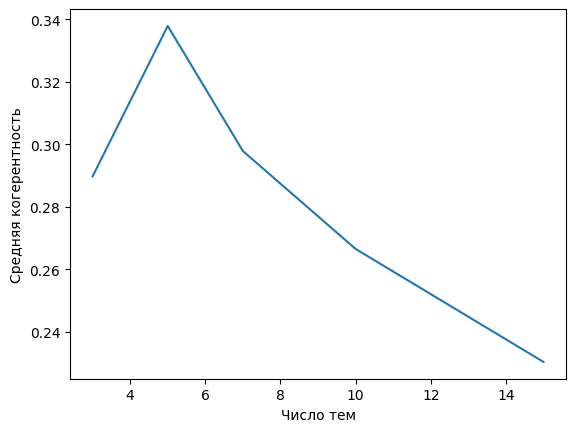

CPU times: user 7min 51s, sys: 1.8 s, total: 7min 53s
Wall time: 7min 53s


In [25]:
%%time

topics_list = [3, 5, 7, 10, 15]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=10000, update_every=1, passes=4)
    coherences.append(CoherenceModel(model=lda, texts=sentences, dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

С числом тем не угадали. Переобучим модель на num_topics=5.

In [27]:
NUM_TOPICS = 5

In [28]:
%%time

lda_best = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=NUM_TOPICS, chunksize=10000, update_every=1, passes=4)

CPU times: user 1min 41s, sys: 296 ms, total: 1min 41s
Wall time: 1min 41s


In [29]:
lda_best.show_topics(num_topics=NUM_TOPICS, num_words=30, log=False, formatted=True)

[(0,
  '0.010*"самый" + 0.009*"писать" + 0.008*"читать" + 0.008*"свой" + 0.007*"большой" + 0.007*"твиттер" + 0.006*"хороший" + 0.006*"ужасный" + 0.006*"знать" + 0.005*"чувство" + 0.005*"нравиться" + 0.005*"блин" + 0.005*"экзамен" + 0.005*"проблема" + 0.005*"вообще" + 0.005*"плохой" + 0.004*"целый" + 0.004*"жаль" + 0.004*"сдать" + 0.004*"делать" + 0.004*"стать" + 0.004*"нормальный" + 0.004*"красивый" + 0.003*"фильм" + 0.003*"книга" + 0.003*"говорить" + 0.003*"слеза" + 0.003*"голос" + 0.003*"работать" + 0.003*"девушка"'),
 (1,
  '0.019*"любить" + 0.017*"спать" + 0.014*"час" + 0.012*"утро" + 0.011*"друг" + 0.010*"настроение" + 0.010*"ждать" + 0.010*"2" + 0.009*"3" + 0.008*"ночь" + 0.008*"хороший" + 0.007*"завтра" + 0.006*"прийтись" + 0.006*"сон" + 0.006*"5" + 0.006*"—" + 0.006*"жаль" + 0.006*"любимый" + 0.006*"вообще" + 0.006*"4" + 0.005*"делать" + 0.005*"неделя" + 0.005*"работа" + 0.005*"самый" + 0.005*"проснуться" + 0.005*"вставать" + 0.005*"добрый" + 0.005*"ранний" + 0.005*"жалко" + 0.

In [30]:
%%time
vis_data = gensimvis.prepare(lda_best, corpus, dictionary)
pyLDAvis.display(vis_data)

/home/gans/anaconda3/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: user 16.4 s, sys: 156 ms, total: 16.5 s
Wall time: 17.7 s


Вот теперь явных пересечений нет

In [31]:
print('Персплексия: ', np.exp(lda_best.log_perplexity(corpus)))

Персплексия:  0.00019835630787823954


In [32]:
coherence_model_lda_best = CoherenceModel(model=lda_best, texts=sentences, dictionary=dictionary, coherence='c_v')
coherence_lda_best = coherence_model_lda_best.get_coherence()
print('Средняя когерентность: ', coherence_lda_best)

Средняя когерентность:  0.28410073246903417


Метрики улучшились

**Вывод:**  
После подбора, количество тем стало оптимально. Они не пересекаются и находяться на большом растоянии друг от друга. Из этого можно сделать вывод, что с реальным числом глобальных тем мы близки, так как если бы их было например меньше, то темы бы сильно пересекались друг с другом.

Большое значение, также, имеет подготовка данных. Изначально браб обработку из лекции, но результат был хуже.  

Наведя на каждый кружок, справа можно посмотреть на то, как часто слово используется в данной теме, относительно общего использовния. Так же это характеризует, как сильно слово описывает выбранную тему.